In [1]:
#Classification of MNIST dataset 
experiment = "5b"
push!(LOAD_PATH, join(["/home/jberez/Projects/OptDigits/dockeropt",experiment]))

using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Random
using Distances
using Flux
using StatsBase
using MultivariateStats
using IterTools #Only for plots, not for program
using Serialization
using BNN

include(join(["dockeropt",experiment,"/utils.jl"]));
include(join(["dockeropt",experiment,"/LoadData.jl"]));

┌ Info: Precompiling BNN [top-level]
└ @ Base loading.jl:1260


In [2]:
#Load exact train and test sets according to original PCA transform
xt = deserialize(join(["/home/jberez/Projects/OptDigits/Data/Opt",experiment,"/OPT_Train",experiment,".jld"]));
xz = deserialize(join(["/home/jberez/Projects/OptDigits/Data/Opt",experiment,"/OPT_Test",experiment,".jld"]));

In [3]:
folder = join(["/Data/Opt",experiment,"/"])
traces = []
tests = [i for i=1:16]
#filename_pre = "trace"
filename_pre = join(["OPTtrace",experiment])
filename_end = "output.jld"

good_traces = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
#good_traces = [1,2,3,4]

for i in good_traces
    current_file = join([pwd(),folder,filename_pre,"$(tests[i])", filename_end])
    current_traces = deserialize(current_file)
    push!(traces,current_traces)
end;
chains = length(traces);

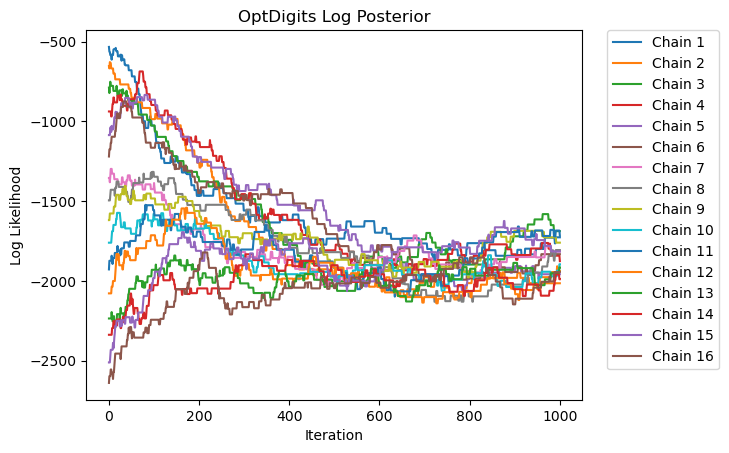

In [4]:
#Plot Log Posterior for Each Chain

for i=1:chains
    scores = zeros(length(traces[i]))
    for j=1:length(traces[i])
        trace = traces[i][j]
        scores[j] = get_score(trace)
    end
    plot(scores,label="Chain $i")
end
plt.title("OptDigits Log Posterior")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood");
#plt.ylim(-500,-100)

legend(bbox_to_anchor=[1.05,1],loc=2,borderaxespad=0);

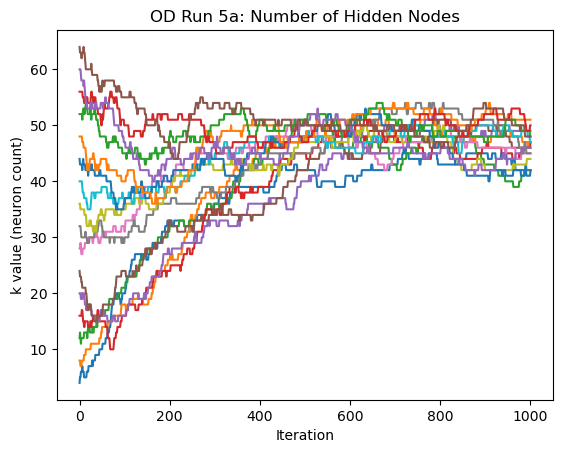

In [5]:
#Node Count Chart
for i=1:chains
    plot([trace[(:k,1)] for trace in traces[i]])
end
plt.title("OD Run 5a: Number of Hidden Nodes")
plt.xlabel("Iteration")
plt.ylabel("k value (neuron count)");

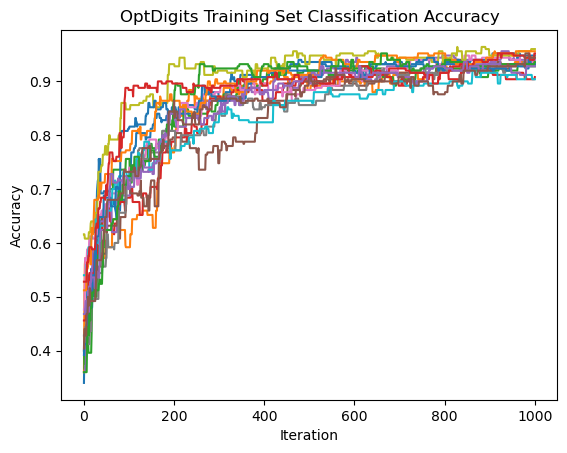

In [6]:
#Plot Training Accuracy
for v=1:chains
    active_traces = traces[v]
    accs = []
    dists = []
    for i = 1:length(active_traces)
        trace = active_traces[i]
        test_labels = G(xt,trace)
        results = label_output(test_labels)
        test_acc = sum([y[i] == results[i] for i=1:length(y)])/length(y)
        test_dist = sum([euclidean(yt[:,j],test_labels[:,j]) for j=1:length(y)])
        push!(accs,test_acc)
        push!(dists,test_dist)
    end
    plot(accs)
end

plt.title("OptDigits Training Set Classification Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy");

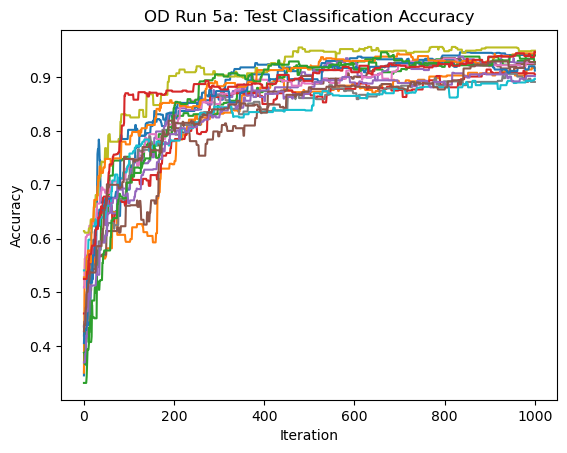

In [13]:
#Plot Test Accuracy
for v=1:chains
    active_traces = traces[v]
    accs = []
    dists = []
    for i = 1:length(active_traces)
        trace = active_traces[i]
        test_labels = G(xz,trace)
        results = label_output(test_labels)
        test_acc = sum([y_test[i] == results[i] for i=1:length(y_test)])/length(y_test)
        #test_dist = sum([euclidean(yzt[:,j],test_labels[:,j]) for j=1:length(y_test)])
        push!(accs,test_acc)
        #push!(dists,test_dist)
    end
    plot(accs)
end

plt.title("OD Run 5a: Test Classification Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy");

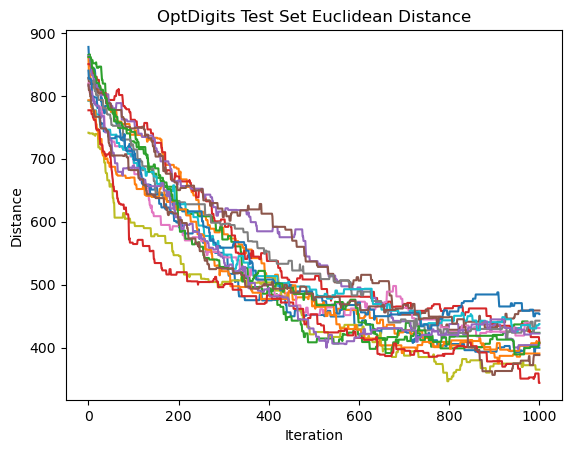

In [8]:
#Plot Test Distance

for v=1:chains
    active_traces = traces[v]
    accs = []
    dists = []
    for i = 1:length(active_traces)
        trace = active_traces[i]
        test_labels = G(xz,trace)
        #results = label_output(test_labels)
        #test_acc = sum([y_test[i] == results[i] for i=1:length(y_test)])/length(y_test)
        test_dist = sum([euclidean(yzt[:,j],test_labels[:,j]) for j=1:length(y_test)])
        #push!(accs,test_acc)
        push!(dists,test_dist)
    end
    plot(dists)
end

plt.title("OptDigits Test Set Euclidean Distance")
plt.xlabel("Iteration")
plt.ylabel("Distance");

In [7]:
#Random Sample Marginalize Training Set
c = 5
N = 250
iters = 1000
burn_in = 500
targets = zeros(iters,c,N)
count = 1
for i=1:iters
    chain = rand(1:16)
    iter = rand(burn_in:1001)
    trace = traces[chain][iter]
    labels = G(xt,trace)
    targets[i,:,:] = labels
end
sums = sum(targets,dims=1)[1,:,:]./(iters)
guesses = [findmax(sums[:,i])[2] for i=1:N]
test_acc = sum([y[i] == guesses[i] for i=1:length(y)])
println("Training set accuracy: $test_acc")
real_acc = 100*(test_acc/N) #98.8%
println("Proportion: $(real_acc)%")

Training set accuracy: 247
Proportion: 98.8%


In [8]:
#Random Sample Marginalize Test Set
c = 5
N = 1000
iters = 1000
burn_in = 500
targets = zeros(iters,c,N)
count = 1
for i=1:iters
    chain = rand(1:16)
    iter = rand(burn_in:1001)
    trace = traces[chain][iter]
    labels = G(xz,trace)
    targets[i,:,:] = labels
end
sums = sum(targets,dims=1)[1,:,:]./(iters)
guesses = [findmax(sums[:,i])[2] for i=1:N]
test_acc = sum([y_test[i] == guesses[i] for i=1:length(y_test)])
println("Training set accuracy: $test_acc")
real_acc = 100*(test_acc/N) #97.5%
println("Proportion: $(real_acc)%")

Training set accuracy: 975
Proportion: 97.5%


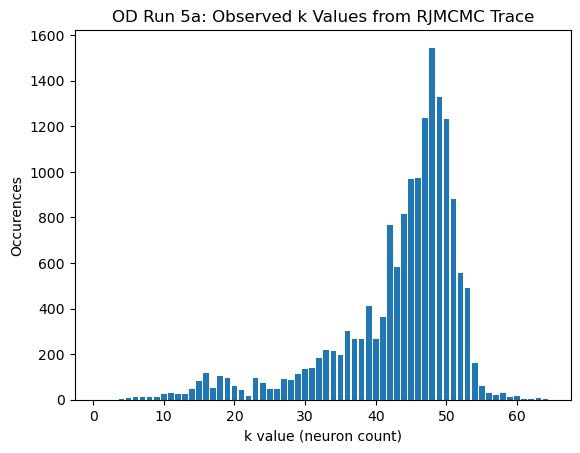

In [12]:
#Hidden Node Counts
k_list = [i for i in 1:64]

ls = [[traces[i][j][(:k,1)] for j=1:length(traces[i])] for i=1:chains]
ls = collect(Iterators.flatten(ls))

counts = [sum([k_list[ls[i]] == j for i in 1:length(ls)]) for j in k_list]
bar(k_list,counts)

plt.title("OD Run 5a: Observed k Values from RJMCMC Trace")
plt.xlabel("k value (neuron count)")
plt.ylabel("Occurences");

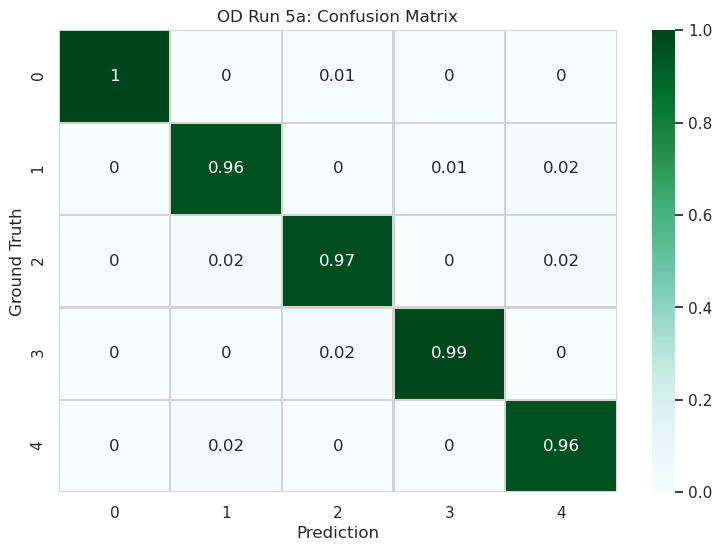

In [10]:
using Seaborn

function confusion_matrix(y_cond::Vector{Int}, y_pred::Vector{Int})

    # Generate empty confusion matrix
    classes = sort(unique([y_cond; y_pred]))
    conf_matrix = zeros(Int64, length(classes), length(classes))

    # Add counts
    for i in 1:length(y_cond)
        # translate label to index
        cond_class_index = y_cond[i]#findfirst(classes, y_cond[i])
        pred_class_index = y_pred[i]#findfirst(classes, y_pred[i])
        # predicted class is the row, condition class is the column
        conf_matrix[pred_class_index, cond_class_index] += 1
  end
  conf_matrix = conf_matrix ./ 200
  return conf_matrix
end

confmat = confusion_matrix(y_test, guesses)
confmat = round.(confmat,digits=2)
fig, ax = plt.subplots(figsize=(9,6)) 
Seaborn.set(font_scale=1.0) 
Seaborn.heatmap(confmat,
    vmin=0.0,
    vmax=1.0,
    annot=true,
    square=false,
    ax=ax,
    linecolor="LightGrey",
    linewidth=0.8,
    cmap="BuGn");
plt.title("OD Run 5a: Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Ground Truth");

In [9]:
#Marginalize Probabilities - Train Set
j = 200
c = 5
N = 250
total_count = sum([length(traces[i]) for i=1:chains])
targets = zeros(total_count-(chains*j),c,N)
for v=1:chains
    active_traces = traces[v]
    count = 1
    for i=j:length(active_traces)-j
        trace = active_traces[i]
        labels = G(xt,trace)
        targets[count,:,:] = labels
        count += 1
    end
end

sums = sum(targets,dims=1)[1,:,:]./(total_count)
guesses = [findmax(sums[:,i])[2] for i=1:N]
test_acc = sum([y[i] == guesses[i] for i=1:length(y)])
println("Training set accuracy: $test_acc")

Training set accuracy: 222


In [10]:
#Marginalize Probabilities - Test Set
j = 200
c = 5
N = 1000
total_count = sum([length(traces[i]) for i=1:chains])
targets = zeros(total_count-(chains*j),c,N)
for v=1:chains
    active_traces = traces[v]
    count = 1
    for i=j:length(active_traces)-j
        trace = active_traces[i]
        labels = G(xz,trace)
        targets[count,:,:] = labels
        count += 1
    end
end

sums = sum(targets,dims=1)[1,:,:]./(total_count)
guesses = [findmax(sums[:,i])[2] for i=1:N]
test_acc = sum([y_test[i] == guesses[i] for i=1:length(y_test)])
println("Test set accuracy: $test_acc")

Test set accuracy: 880


In [56]:
#Acceptance Probability
#folder = "/Data/BostonLong/"
#folder = "/Data/BostonFour/"
folder = "/Data/Opt2/"

filename_pre = "OPT"
filename_endA = "AcceptanceA.jld"
filename_endW = "AcceptanceW.jld"

current_file = join([pwd(),folder,filename_pre,filename_endA])
across = deserialize(current_file)
current_file = join([pwd(),folder,filename_pre,filename_endW])
within = deserialize(current_file)

across_accs = [sum(i)/length(i) for i in across]
across_total = sum(collect(Iterators.flatten(across)))/length(collect(Iterators.flatten(across)))

within_accs = [sum(i)/length(i) for i in within]
within_total = sum(collect(Iterators.flatten(within)))/length(collect(Iterators.flatten(within)))
println("Across Accuracy: $across_total")
println("Within Accuracy: $within_total")

Across Accuracy: Any[]
Within Accuracy: Any[]


In [16]:
#OLD OPTDIGITS JUNK

#Read Optdigits CSV
#using CSV
#using DataFrames

#test = CSV.read("dockeropt/optdigits.csv", DataFrame)
#y_total = Array(test[:,65]) .+ 1
#x_total = Array(test[:,1:64]);
#x_total = [Float64(i) for i in x_total]
x_total = deserialize("dockeropt5b/optdigits_x.jld")
y_total = deserialize("dockeropt5b/optdigits_y.jld")

#display(x_total[1:5,:])

dx = fit(ZScoreTransform, x_total, dims=2)
StatsBase.transform!(dx, x_total);

#display(x_total[1:5,:])

#Load Train and Test Sets

function balanced_set(x,y,n,c,seed=0)
    
    if seed != 0
        Random.seed!(seed)
    end
    
    shuffled_indices = shuffle(1:length(y))
    x = x[shuffled_indices,:]
    y = y[shuffled_indices]
    
    x_ordered = zeros(Float64,n*c,64)
    y_ordered = zeros(Int,n*c)
    for k=1:c
        labels = [i for i in 1:length(y) if y[i]==k]
        x_ordered[k*n-(n-1):k*n,:] = x[labels,:][1:n,:]
        y_ordered[k*n-(n-1):k*n] = y[labels][1:n]
    end
    return x_ordered, y_ordered
end

function reshape_x(x)
    n = size(x)[1]
    println(n)
    x_reshaped = zeros(Float64, 8, 8, n)
    for i=1:n
        test = reshape(x[i,:], (1,8,8))
        x_reshaped[:,:,i] = reshape(x[i,:], (8,8))
    end
    return x_reshaped
end;

#Load the OptDigits Data
num_samples = 50
num_classes = 5

x_train, y_train = balanced_set(x_total,y_total,num_samples,num_classes,1);
x_test, y_test = balanced_set(x_total,y_total,num_samples,num_classes,2);
x_full, y_full = balanced_set(x_total, y_total,200,num_classes,300);

#Prepare full test set

#Standardize x Data
dx = fit(ZScoreTransform, x_total, dims=2)
StatsBase.transform!(dx, x_total)
x_test, y_test = balanced_set(x_total,y_total,num_samples,num_classes,300)

#Load the OptDigits Data
num_samples = 100
num_classes = 5

#x_train, y_train = balanced_set(x_total,y_total,num_samples,num_classes,1);#Random seed 1 for train data
#x_test, y_test = balanced_set(x_total,y_total,num_samples,num_classes,300);#Random seed 2 for test data

#Get PCA Transform for x
x = transpose(x_train)

#########
dims = 20
#########

x_pca = fit(PCA,x,maxoutdim=dims)
xt = MultivariateStats.transform(x_pca,x)

#Testing PCA Transform
xz = MultivariateStats.transform(x_pca,transpose(x_test));

#Full PCA Transform
xf = MultivariateStats.transform(x_pca,transpose(x_full));

#One-Hot Encode Y
y = y_train
#yt = Flux.onehotbatch(y,[:1,:2,:3,:4,:5,:6,:7,:8,:9,:10]);
yt = Flux.onehotbatch(y,[:1,:2,:3,:4,:5]);
#Test Set
yz = y_test
#yzt = Flux.onehotbatch(yz,[:1,:2,:3,:4,:5,:6,:7,:8,:9,:10]);
yzt = Flux.onehotbatch(yz,[:1,:2,:3,:4,:5]);
#Full Test Set
yf = y_full
#yft = Flux.onehotbatch(yf,[:1,:2,:3,:4,:5,:6,:7,:8,:9,:10]);
yft = Flux.onehotbatch(yf,[:1,:2,:3,:4,:5]);

#x_total_pca = MultivariateStats.transform(x_pca,transpose(x_total));